1. Prepare the data

1.1. Open the files and look into the data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer


data_train=pd.read_csv('/datasets/gold_recovery_train.csv')
data_test=pd.read_csv('/datasets/gold_recovery_test.csv')
data_full=pd.read_csv('/datasets/gold_recovery_full.csv')

#print(data_train.head(10))
#print(data_test.head(10))
print(data_full.head(10))
print(data_full.columns)


                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   
5  2016-01-15 05:00:00                     6.482968   
6  2016-01-15 06:00:00                     6.533849   
7  2016-01-15 07:00:00                     6.130823   
8  2016-01-15 08:00:00                     5.834140   
9  2016-01-15 09:00:00                     5.687063   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   
5         

1.2. Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.

In [ ]:
#filling NaN values with ffill method for training set

#print(data_train.columns)
#print(data_train.info())

data_train_new=data_train.dropna()

r_target=data_train_new['rougher.output.recovery']
C=data_train_new['rougher.output.concentrate_au']
F=data_train_new['rougher.input.feed_au']
T=data_train_new['rougher.output.tail_au']

data_train_new['recovery_cal']=((C*(F-T))/(F*(C-T)))*100

mae=np.sum(np.abs(data_train_new['recovery_cal']-r_target))/len(r_target)
print(mae)


9.555596961987514e-15


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Mean absolute error between the calculated recovery and target recovery is very small which implies that the both the recovery values are similar and recovery has been calculated correctly.

1.3. Analyze the features not available in the test set. What are these parameters? What is their type?

In [ ]:
train=data_train.head()
test=data_test.head()

test_mis_col=[]
for i in list(train):
    if i not in list(test):
        test_mis_col.append(i)

print(test_mis_col)

['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tai

Majorly, Test set is missig all the output columns for rougher, primay filtration and final concentrate.

1.4. Perform data preprocessing.

In [ ]:
#Changing date column to datetime type in all data sets

data_full['date']=pd.to_datetime(data_full['date'], format='%Y-%m-%dT%H:%M:%S')
data_test['date']=pd.to_datetime(data_test['date'], format='%Y-%m-%dT%H:%M:%S')
data_train['date']=pd.to_datetime(data_train['date'], format='%Y-%m-%dT%H:%M:%S')

#Adding 2 target columns from full data to test data
data_full_sel=data_full.loc[:,['date','rougher.output.recovery','final.output.recovery',
                               'final.output.concentrate_ag','final.output.concentrate_pb', 
                               'final.output.concentrate_sol','final.output.concentrate_au', 
                               'rougher.output.concentrate_ag','rougher.output.concentrate_pb', 
                               'rougher.output.concentrate_sol','rougher.output.concentrate_au']]


#data_test_sel=data_test.merge(data_full_sel, on='date')


#Droping columns from train dataset which are missing in test dataset

data_train_sel=data_train

for i in list(data_train_sel):
    if i not in list(data_test_sel):
        data_train_sel=data_train_sel.drop([i],axis=1)

data_train_sel=data_train_sel.fillna(method='ffill')
data_test_sel=data_test_sel.fillna(method='ffill')
print(data_test_sel.info())
print(data_train_sel.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5856 entries, 0 to 5855
Data columns (total 63 columns):
date                                          5856 non-null datetime64[ns]
primary_cleaner.input.sulfate                 5856 non-null float64
primary_cleaner.input.depressant              5856 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5856 non-null float64
primary_cleaner.state.floatbank8_a_air        5856 non-null float64
primary_cleaner.state.floatbank8_a_level      5856 non-null float64
primary_cleaner.state.floatbank8_b_air        5856 non-null float64
primary_cleaner.state.floatbank8_b_level      5856 non-null float64
primary_cleaner.state.floatbank8_c_air        5856 non-null float64
primary_cleaner.state.floatbank8_c_level      5856 non-null float64
primary_cleaner.state.floatbank8_d_air        5856 non-null float64
primary_cleaner.state.floatbank8_d_level      5856 non-null float64
ro

2. Analyze the data

2.1. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

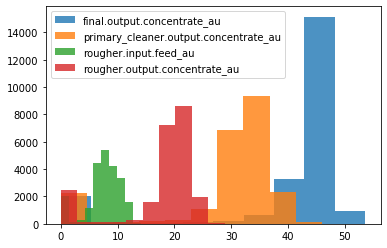

In [ ]:
metals_au=['rougher.input.feed_au','final.output.concentrate_au','primary_cleaner.output.concentrate_au', 'rougher.output.concentrate_au']

kwargs_au=dict(alpha=0.8)
for i in list(data_full):
    if i in list(metals_au):
        plt.hist(data_full[i],**kwargs_au, label=i)
        plt.legend()

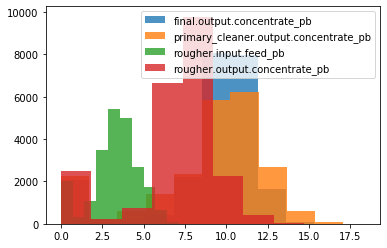

In [ ]:
metals_pb=['rougher.input.feed_pb','final.output.concentrate_pb','primary_cleaner.output.concentrate_pb', 'rougher.output.concentrate_pb']

kwargs_pb=dict(alpha=0.8)
for j in list(data_full):
    if j in list(metals_pb):
        plt.hist(data_full[j],**kwargs_pb, label=j)
        plt.legend()
    

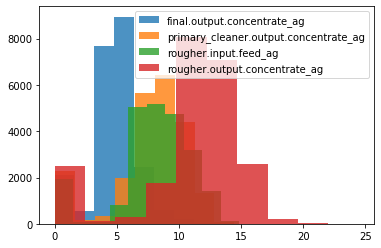

In [ ]:
metals_ag=['rougher.input.feed_ag','final.output.concentrate_ag','primary_cleaner.output.concentrate_ag', 'rougher.output.concentrate_ag']

kwargs_ag=dict(alpha=0.8)
for k in list(data_full):
    if k in list(metals_ag):
        plt.hist(data_full[k],**kwargs_ag, label=k)
        plt.legend()

1. Concentration of AU is highest in the final stage and the overlap between stages is very less
2. For Pb, the metal value is lowest in the final output concentrate
3. For Ag, the concentration is high in both rougher output and final putput. The concentration in rougher output varies from 0 to >20.

2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.

(0, 350)

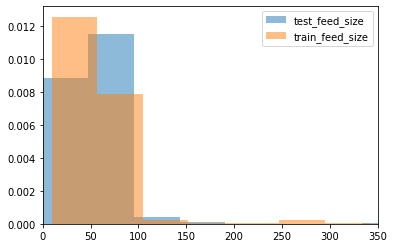

In [ ]:
kwargs_ps=dict(alpha=0.5, density=True, stacked=True)

plt.hist(data_test_sel['rougher.input.feed_size'], **kwargs_ps, label='test_feed_size')
plt.hist(data_train_sel['rougher.input.feed_size'], **kwargs_ps, label='train_feed_size')
plt.legend()
plt.xlim(0,350)

Since train dataset has very large no of observations compared to test dataset, hence normalized the plot. The distribtuion shows that feed size for both test and train dataset is similar.

2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.

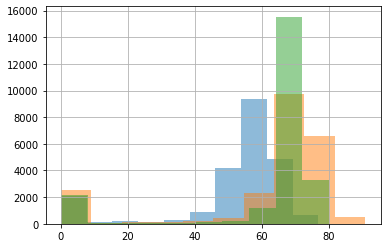

In [ ]:
#Identifying outliers from full data

input_feed=['rougher.input.feed_ag','rougher.input.feed_pb','rougher.input.feed_sol','rougher.input.feed_au']
data_full[input_feed].sum(1).hist(alpha=0.5)

rougher_output=['rougher.output.concentrate_ag','rougher.output.concentrate_pb','rougher.output.concentrate_sol','rougher.output.concentrate_au']
data_full[rougher_output].sum(1).hist(alpha=0.5)

final_output=['final.output.concentrate_ag', 'final.output.concentrate_pb','final.output.concentrate_sol','final.output.concentrate_au']
data_full[final_output].sum(1).hist(alpha=0.5)


There are below 10 values which are outliers.

In [ ]:
#removing outliers from train and test set

data_train_sel['input_feed_tot']=data_train_sel[input_feed].sum(1)
data_train_sel['rougher_output_tot']=data_train_sel[rougher_output].sum(1)
data_train_sel['final_output_tot']=data_train_sel[final_output].sum(1)  

data_train_final=data_train_sel.query('input_feed_tot>10')
data_train_final=data_train_final.query('rougher_output_tot>10')
data_train_final=data_train_final.query('final_output_tot>10')

data_test_sel['input_feed_tot']=data_test_sel[input_feed].sum(1)
data_test_sel['rougher_output_tot']=data_test_sel[rougher_output].sum(1)
data_test_sel['final_output_tot']=data_test_sel[final_output].sum(1)  

data_test_final=data_test_sel.query('input_feed_tot>10')
data_test_final=data_test_final.query('rougher_output_tot>10')
data_test_final=data_test_final.query('final_output_tot>10')


print(data_train_final.info())
print(data_test_final.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14550 entries, 0 to 16859
Data columns (total 66 columns):
date                                          14550 non-null datetime64[ns]
final.output.concentrate_ag                   14550 non-null float64
final.output.concentrate_pb                   14550 non-null float64
final.output.concentrate_sol                  14550 non-null float64
final.output.concentrate_au                   14550 non-null float64
final.output.recovery                         14550 non-null float64
primary_cleaner.input.sulfate                 14550 non-null float64
primary_cleaner.input.depressant              14550 non-null float64
primary_cleaner.input.feed_size               14550 non-null float64
primary_cleaner.input.xanthate                14550 non-null float64
primary_cleaner.state.floatbank8_a_air        14550 non-null float64
primary_cleaner.state.floatbank8_a_level      14550 non-null float64
primary_cleaner.state.floatbank8_b_air        14550 non-

After removing outliers, test set observations reduced from 5856 to 5270 and Train set observations reduced from 16860 to 14550. Test set reduced by 10% while train set reduced by 14%.

3. Build the model

3.1. Write a function to calculate the final sMAPE value.

In [ ]:
def final_SMAPE(target, predicted):
    return 100 / len(target) * np.sum(2 * np.abs(predicted - target) / (np.abs(target) + np.abs(predicted)))

3.2. Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

In [ ]:
features_train=data_train_final.drop(['date','rougher.output.recovery','final.output.recovery'], axis=1)
target_train_1=data_train_final['rougher.output.recovery']
target_train_2=data_train_final['final.output.recovery']


features_test=data_test_final.drop(['date','rougher.output.recovery','final.output.recovery'], axis=1)
target_test_1= data_test_final['rougher.output.recovery']
target_test_2= data_test_final['final.output.recovery']

scaler=StandardScaler()
features_train=scaler.fit_transform(features_train)
new_scorer = make_scorer(final_SMAPE, greater_is_better=False)

In [ ]:
#Decision Tree hypertuning
print('decisionTree_Model_1')
for depth in range(1,11):
    model_dr_1 = DecisionTreeRegressor(random_state=12345, max_depth = depth)
    dr_cross_val_scores_1 = cross_val_score(model_dr_1, features_train,target_train_1,scoring = new_scorer,cv=5).mean()    
    print("max_depth =", depth, ": ","Cross Val Score_1",(dr_cross_val_scores_1*-1))

print('decisionTree_Model_2')
for depth in range(1,11):
    model_dr_2 = DecisionTreeRegressor(random_state=12345, max_depth = depth)
    dr_cross_val_scores_2 = cross_val_score(model_dr_2, features_train,target_train_2,scoring = new_scorer,cv=5).mean()
    print("max_depth =", depth, ": ","Cross Val Score_2",(dr_cross_val_scores_2*-1))

decisionTree_Model_1
max_depth = 1 :  Cross Val Score_1 8.127788053858476
max_depth = 2 :  Cross Val Score_1 7.940945687325781
max_depth = 3 :  Cross Val Score_1 7.563075456747038
max_depth = 4 :  Cross Val Score_1 7.729098186101327
max_depth = 5 :  Cross Val Score_1 7.9539572061101165
max_depth = 6 :  Cross Val Score_1 7.786017807137315
max_depth = 7 :  Cross Val Score_1 8.278692246206754
max_depth = 8 :  Cross Val Score_1 8.507310125856081
max_depth = 9 :  Cross Val Score_1 9.04473078307517
max_depth = 10 :  Cross Val Score_1 9.476045727862012
decisionTree_Model_2
max_depth = 1 :  Cross Val Score_2 10.546315814703046
max_depth = 2 :  Cross Val Score_2 10.344888011467813
max_depth = 3 :  Cross Val Score_2 10.21484908662821
max_depth = 4 :  Cross Val Score_2 10.295770190492583
max_depth = 5 :  Cross Val Score_2 10.432688894089889
max_depth = 6 :  Cross Val Score_2 11.754310112474538
max_depth = 7 :  Cross Val Score_2 10.823686574041876
max_depth = 8 :  Cross Val Score_2 12.333413402783

In [ ]:
#Random Forest hypertuning

print('RandomForest_1')
for estimator in range(15,21):
    model_rf_1 =RandomForestRegressor(n_estimators=estimator,random_state=12345)
    rf_scores_1 = cross_val_score(model_rf_1, features_train,target_train_1,scoring = new_scorer,cv=5).mean()    
    print("n_estimators =", estimator, ": ","Cross Val Score_1",(rf_scores_1*-1))

print('RandomForest_2')
for estimator in range(15,21):
    model_rf_2 =RandomForestRegressor(n_estimators=estimator,random_state=12345)
    rf_scores_2 = cross_val_score(model_rf_2, features_train,target_train_2,scoring = new_scorer,cv=5).mean()    
    print("n_estimators =", estimator, ": ","Cross Val Score_2",(rf_scores_2*-1))

RandomForest_1
n_estimators = 15 :  Cross Val Score_1 8.457093025478937
n_estimators = 16 :  Cross Val Score_1 8.472658569325343
n_estimators = 17 :  Cross Val Score_1 8.44769076869101
n_estimators = 18 :  Cross Val Score_1 8.491592367175048
n_estimators = 19 :  Cross Val Score_1 8.468957862752731
n_estimators = 20 :  Cross Val Score_1 8.525140090324097
RandomForest_2
n_estimators = 15 :  Cross Val Score_2 10.444883964986886
n_estimators = 16 :  Cross Val Score_2 10.389461275627744
n_estimators = 17 :  Cross Val Score_2 10.351942126145115
n_estimators = 18 :  Cross Val Score_2 10.238141715069025
n_estimators = 19 :  Cross Val Score_2 10.232507357084309
n_estimators = 20 :  Cross Val Score_2 10.157016546922273


In [ ]:
#Linear regression

model_lr_1 = LinearRegression()
lr_scores_1 = cross_val_score(model_lr_1, features_train,target_train_1,scoring = new_scorer,cv=5).mean()
print(lr_scores_1*-1)

model_lr_2 = LinearRegression()
lr_scores_2 = cross_val_score(model_lr_2, features_train,target_train_2,scoring = new_scorer,cv=5).mean()
print(lr_scores_2*-1)


7.79552713445257
11.795189022942727


Based on the model training and parameter hypertuning, decision Tree is selected as final model.

In [ ]:
#testing the selected model with test dataset

final_dr_1 = DecisionTreeRegressor(random_state=12345, max_depth = 3)
final_dr_1.fit(features_train, target_train_1)
predictions_test_1 = final_dr_1.predict(features_test)
SMAPE_rougher=final_SMAPE(target_test_1,predictions_test_1)
print(SMAPE_rougher)

final_dr_2 = DecisionTreeRegressor(random_state=12345, max_depth = 1)
final_dr_2.fit(features_train, target_train_2)
predictions_test_2 = final_dr_2.predict(features_test)
SMAPE_final= final_SMAPE(target_test_2,predictions_test_2)
print(SMAPE_final)

sMAPE=(0.25*SMAPE_rougher+0.75*SMAPE_final)
print(sMAPE)

5.581316321235855
7.976209535894966
7.377486232230188


new_scorer is defined using make_scorer and used in the cross_val_score.

Baseline Model

In [ ]:
from sklearn.dummy import DummyRegressor
dummy_regr_1 = DummyRegressor(strategy="mean")
dummy_regr_1.fit(features_train, target_train_1)
dummy_regr_1_pred = dummy_regr_1.predict(features_test)
SMAPE_rougher_dummy_regr= final_SMAPE(target_test_1,dummy_regr_1_pred)
print(SMAPE_rougher_dummy_regr)

from sklearn.dummy import DummyRegressor
dummy_regr_2 = DummyRegressor(strategy="mean")
dummy_regr_2.fit(features_train, target_train_2)
dummy_regr_2_pred = dummy_regr_2.predict(features_test)
SMAPE_final_dummy_regr= final_SMAPE(target_test_2,dummy_regr_2_pred)
print(SMAPE_final_dummy_regr)

final_SMAPE_dummy_regr=(0.25*SMAPE_rougher_dummy_regr+0.75*SMAPE_final_dummy_regr)
print(final_SMAPE_dummy_regr)

5.955561782089875
8.860485576304232
8.134254627750643


The selected model has scores less than the baseline model, hence the selected model pass the sanity check.

Hypertuning done and added a baseline model for sanity check.